## Modelo 1

Se cargan las librerías.

In [41]:
import pandas as pd
from sklearn.model_selection import train_test_split, GridSearchCV
from imblearn.under_sampling import RandomUnderSampler
from sklearn.pipeline import Pipeline
from sklearn.feature_selection import SelectKBest
from sklearn.ensemble import RandomForestClassifier
import numpy as np
from sklearn.preprocessing import StandardScaler

from sklearn.metrics import confusion_matrix
import seaborn as sns
import pickle
import yaml

Se cargan los datos procesados.

In [4]:
segmentos = []

# Leer los archivos CSV segmentados y almacenarlos en la lista
for i in range(0,3):
    segmento = pd.read_csv(f'../data/processed/segmento_{i+1}.csv')
    segmentos.append(segmento)
# Concatenar los DataFrames de los segmentos en uno solo
df1 = pd.concat(segmentos, ignore_index=True)

In [68]:
df1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1296675 entries, 0 to 1296674
Data columns (total 9 columns):
 #   Column                 Non-Null Count    Dtype  
---  ------                 --------------    -----  
 0   amt                    1296675 non-null  float64
 1   city_pop               1296675 non-null  int64  
 2   is_fraud               1296675 non-null  int64  
 3   distancia              1296675 non-null  float64
 4   fraudes_por_Categoria  1296675 non-null  float64
 5   fraudes_por_estado     1296675 non-null  float64
 6   fraudes_por_edad       1296675 non-null  float64
 7   fraudes_por_hora       1296675 non-null  float64
 8   fraudes_por_día        1296675 non-null  float64
dtypes: float64(7), int64(2)
memory usage: 89.0 MB


Se separa el test del Dataframe original no balanceado para asegurar que los datos nuevos serán similares a los reales a predecir, manteniendo proporción en los datos

In [5]:
# Crear las variables para features y target
X = df1[['amt', 'city_pop', 'distancia', 'fraudes_por_Categoria',
       'fraudes_por_estado', 'fraudes_por_edad', 'fraudes_por_hora',
       'fraudes_por_día']]
y = df1['is_fraud']

# Separamos una muestra del DataFrame para probar el modelo
X_train, X_test, y_train, y_test = train_test_split(X,
                                                   y,
                                                   test_size = 0.1,
                                                   random_state=0, stratify=y)


Una vez obtenido el test, se pasa a balancear los datos, tanto para aligerar la carga del entrenamiento, como para intentar que el modelo prediga mejor la clase minoritaría.

In [8]:
# Aplicamos undersampling a los datos
rus = RandomUnderSampler()

X_resampled, y_resampled = rus.fit_resample(X_train, y_train)

# Separamos el nuevo conjunto en X e y
X_under = X_resampled
y_under = y_resampled

Se separa en train y test.

Con un GridSearch, se hiperparametriza un RandomForestClassifier.

In [80]:
# Definir el pipeline
pipe = Pipeline(steps=[
    ("scaler", StandardScaler()),
    ("selectkbest", SelectKBest()),
    ("classifier", RandomForestClassifier())
])

# Definir los parámetros del GridSearchCV
rf_params = {
    'scaler': [StandardScaler(), None],
    'selectkbest__k': np.arange(7, 9),
    'classifier__criterion':["gini", "entropy"],
    'classifier__max_features': np.arange(5, 7),
    'classifier__max_depth': np.arange(2, 9),
    'classifier__class_weight': [{0: 100, 1: 1}, {0:50, 1:1}],  # Asignar mayor peso a la clase 0
    'classifier__min_samples_leaf': np.arange(5, 7),
}

# Crear el GridSearchCV
clf = GridSearchCV(estimator=pipe, param_grid=rf_params, cv=3, scoring="roc_auc")

# Ajustar el GridSearchCV
clf.fit(X_resampled, y_resampled)

GridSearchCV(cv=3,
             estimator=Pipeline(steps=[('scaler', StandardScaler()),
                                       ('selectkbest', SelectKBest()),
                                       ('classifier',
                                        RandomForestClassifier())]),
             param_grid={'classifier__class_weight': [{0: 100, 1: 1},
                                                      {0: 50, 1: 1}],
                         'classifier__criterion': ['gini', 'entropy'],
                         'classifier__max_depth': array([2, 3, 4, 5, 6, 7, 8]),
                         'classifier__max_features': array([5, 6]),
                         'classifier__min_samples_leaf': array([5, 6]),
                         'scaler': [StandardScaler(), None],
                         'selectkbest__k': array([7, 8])},
             scoring='roc_auc')

In [81]:
clf.best_params_

{'classifier__class_weight': {0: 50, 1: 1},
 'classifier__criterion': 'entropy',
 'classifier__max_depth': 8,
 'classifier__max_features': 6,
 'classifier__min_samples_leaf': 5,
 'scaler': StandardScaler(),
 'selectkbest__k': 7}

In [82]:
predictions = clf.predict(X_test)

[[128269    648]
 [   130    621]]


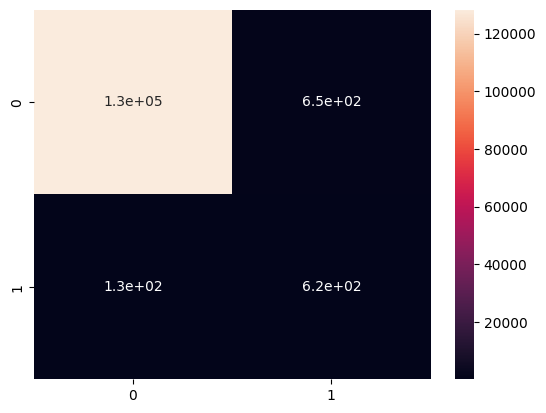

In [83]:
c_matrix = confusion_matrix(y_test, predictions)
print(c_matrix)
sns.heatmap(c_matrix, annot=True);

In [21]:
from sklearn.metrics import precision_score, recall_score, roc_auc_score

In [85]:
precision_score(y_test, predictions)

0.48936170212765956

In [86]:
recall_score(y_test, predictions)

0.8268974700399467

In [87]:
roc_auc_score(y_test, predictions)

0.9109354900639164

In [93]:
# Definir el pipeline
pipe = Pipeline(steps=[
    ("scaler", StandardScaler()),
    ("selectkbest", SelectKBest()),
    ("classifier", RandomForestClassifier())
])

# Definir los parámetros del GridSearchCV
rf_params = {
    'scaler': [StandardScaler()],
    'selectkbest__k': np.arange(2, 9),
    'classifier__criterion':["gini","entropy"],
    'classifier__max_features': np.arange(6, 9),
    'classifier__max_depth': np.arange(10, 18),
    'classifier__class_weight': [{0: 100, 1: 1}, {0:50, 1:1}],  # Asignar mayor peso a la clase 0
}

# Crear el GridSearchCV
clf = GridSearchCV(estimator=pipe, param_grid=rf_params, cv=3, scoring="precision")

# Ajustar el GridSearchCV
clf.fit(X_resampled, y_resampled)

GridSearchCV(cv=3,
             estimator=Pipeline(steps=[('scaler', StandardScaler()),
                                       ('selectkbest', SelectKBest()),
                                       ('classifier',
                                        RandomForestClassifier())]),
             param_grid={'classifier__class_weight': [{0: 100, 1: 1},
                                                      {0: 50, 1: 1}],
                         'classifier__criterion': ['gini', 'entropy'],
                         'classifier__max_depth': array([10, 11, 12, 13, 14, 15, 16, 17]),
                         'classifier__max_features': array([6, 7, 8]),
                         'scaler': [StandardScaler()],
                         'selectkbest__k': array([2, 3, 4, 5, 6, 7, 8])},
             scoring='precision')

In [18]:
predictions = clf.predict(X_test)

In [94]:
clf.best_params_

{'classifier__class_weight': {0: 100, 1: 1},
 'classifier__criterion': 'gini',
 'classifier__max_depth': 10,
 'classifier__max_features': 7,
 'scaler': StandardScaler(),
 'selectkbest__k': 3}

[[127795   1122]
 [   130    621]]


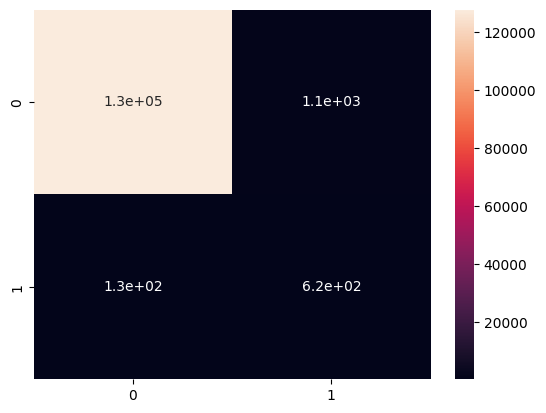

In [19]:
c_matrix = confusion_matrix(y_test, predictions)
print(c_matrix)
sns.heatmap(c_matrix, annot=True);

In [22]:
precision_score(y_test, predictions)

0.35628227194492257

In [23]:
recall_score(y_test, predictions)

0.8268974700399467

In [24]:
roc_auc_score(y_test, predictions)

0.9090970979201339

In [99]:
# Definir el pipeline
pipe = Pipeline(steps=[
    ("scaler", StandardScaler()),
    ("selectkbest", SelectKBest()),
    ("classifier", RandomForestClassifier())
])

# Definir los parámetros del GridSearchCV
rf_params = {
    'scaler': [StandardScaler(), None],
    'selectkbest__k': np.arange(2, 5),
    'classifier__criterion':["gini","entropy"],
    'classifier__max_features': np.arange(6, 9),
    'classifier__max_depth': np.arange(10, 20),
    'classifier__class_weight': [{0: 100, 1: 1}, {0:50, 1:1}],  # Asignar mayor peso a la clase 0
}

# Crear el GridSearchCV
clf = GridSearchCV(estimator=pipe, param_grid=rf_params, cv=3, scoring="roc_auc")

# Ajustar el GridSearchCV
clf.fit(X_resampled, y_resampled)

GridSearchCV(cv=3,
             estimator=Pipeline(steps=[('scaler', StandardScaler()),
                                       ('selectkbest', SelectKBest()),
                                       ('classifier',
                                        RandomForestClassifier())]),
             param_grid={'classifier__class_weight': [{0: 100, 1: 1},
                                                      {0: 50, 1: 1}],
                         'classifier__criterion': ['gini', 'entropy'],
                         'classifier__max_depth': array([10, 11, 12, 13, 14, 15, 16, 17, 18, 19]),
                         'classifier__max_features': array([6, 7, 8]),
                         'scaler': [StandardScaler(), None],
                         'selectkbest__k': array([2, 3, 4])},
             scoring='roc_auc')

In [33]:
predictions= clf.predict(X_test)

In [ ]:
clf.best_params_

{'classifier__class_weight': {0: 100, 1: 1},
 'classifier__criterion': 'entropy',
 'classifier__max_depth': 17,
 'classifier__max_features': 8,
 'scaler': StandardScaler(),
 'selectkbest__k': 4}

[[125149   3768]
 [    32    719]]


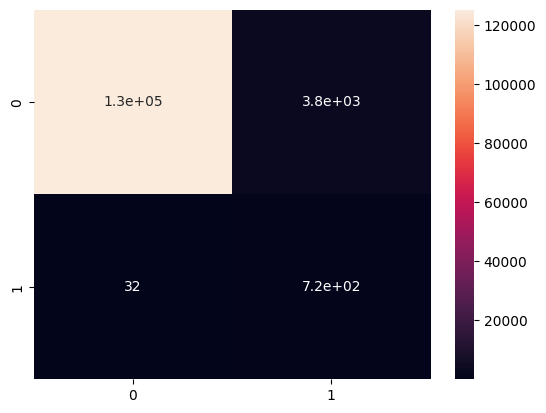

In [34]:
c_matrix = confusion_matrix(y_test, predictions)
print(c_matrix)
sns.heatmap(c_matrix, annot=True);

In [35]:
print("Precision score:", precision_score(y_test, predictions))
print("Recall score:", recall_score(y_test, predictions))
print("ROC AUC score:", roc_auc_score(y_test, predictions))

Precision score: 0.1602406953420994
Recall score: 0.9573901464713716
ROC AUC score: 0.964081019231947


In [36]:
# Definir el pipeline
pipe = Pipeline(steps=[
    ("scaler", StandardScaler()),
    ("selectkbest", SelectKBest()),
    ("classifier", RandomForestClassifier())
])

# Definir los parámetros del GridSearchCV
rf_params = {
    'scaler': [StandardScaler(), None],
    'selectkbest__k': [6],
    'classifier__max_depth': [15],
    'classifier__class_weight': [{0: 1, 1: 50}]
}

# Crear el GridSearchCV
clf = GridSearchCV(estimator=pipe, param_grid=rf_params, cv=3, scoring="roc_auc", verbose=10)

# Ajustar el GridSearchCV
clf.fit(X_train, y_train)


Fitting 3 folds for each of 2 candidates, totalling 6 fits
[CV 1/3; 1/2] START classifier__class_weight={0: 1, 1: 50}, classifier__max_depth=15, scaler=StandardScaler(), selectkbest__k=6
[CV 1/3; 1/2] END classifier__class_weight={0: 1, 1: 50}, classifier__max_depth=15, scaler=StandardScaler(), selectkbest__k=6;, score=0.993 total time= 1.6min
[CV 2/3; 1/2] START classifier__class_weight={0: 1, 1: 50}, classifier__max_depth=15, scaler=StandardScaler(), selectkbest__k=6
[CV 2/3; 1/2] END classifier__class_weight={0: 1, 1: 50}, classifier__max_depth=15, scaler=StandardScaler(), selectkbest__k=6;, score=0.994 total time= 1.6min
[CV 3/3; 1/2] START classifier__class_weight={0: 1, 1: 50}, classifier__max_depth=15, scaler=StandardScaler(), selectkbest__k=6
[CV 3/3; 1/2] END classifier__class_weight={0: 1, 1: 50}, classifier__max_depth=15, scaler=StandardScaler(), selectkbest__k=6;, score=0.995 total time= 1.9min
[CV 1/3; 2/2] START classifier__class_weight={0: 1, 1: 50}, classifier__max_dept

GridSearchCV(cv=3,
             estimator=Pipeline(steps=[('scaler', StandardScaler()),
                                       ('selectkbest', SelectKBest()),
                                       ('classifier',
                                        RandomForestClassifier())]),
             param_grid={'classifier__class_weight': [{0: 1, 1: 50}],
                         'classifier__max_depth': [15],
                         'scaler': [StandardScaler(), None],
                         'selectkbest__k': [6]},
             scoring='roc_auc', verbose=10)

In [37]:
predictions = clf.predict(X_test)

In [38]:
clf.best_params_

{'classifier__class_weight': {0: 1, 1: 50},
 'classifier__max_depth': 15,
 'scaler': None,
 'selectkbest__k': 6}

[[128546    371]
 [   123    628]]


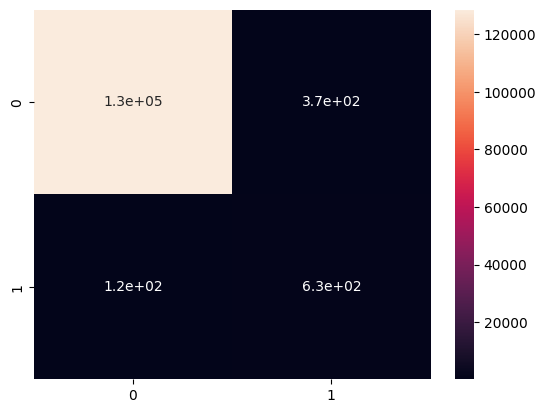

In [39]:
c_matrix = confusion_matrix(y_test, predictions)
print(c_matrix)
sns.heatmap(c_matrix, annot=True);

In [40]:
print("Precision score:", precision_score(y_test, predictions))
print("Recall score:", recall_score(y_test, predictions))
print("ROC AUC score:", roc_auc_score(y_test, predictions))

Precision score: 0.6286286286286287
Recall score: 0.8362183754993342
ROC AUC score: 0.9166702774430358


In [42]:
# Para escribir el archivo pickle
with open('../models/Model1/trained_model.pkl', 'wb') as archivo_salida:
    pickle.dump(clf.best_estimator_, archivo_salida)

# Para escribir el archivo YAML
with open("../models/Model1/model_config.yaml", "w") as f:
    yaml.dump(clf.best_params_, f)

De los modelos hiperparametrizados, este es el mejor, por tanto, se ha guardado en formato pickle.